In [8]:
import kmodels as kmk
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# get torch pretty mokey patch
import lovely_tensors as lt
lt.monkey_patch()
def to_torch(X):
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X.astype(np.float32))
    elif isinstance(X, pd.DataFrame):
        X = X.values
        X = torch.from_numpy(X.astype(np.float32))
    return X
def to_plot_var(x):
    if isinstance(x, torch.Tensor):
        x = x.cpu().detach().numpy()
    return x
# for each subject make a large array of copipes of the x data where each muscle is deleted systematically and then the data is appeneded together
# this will be the input data


def get_cols_names():
    x_cols = ['FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP', 'FPB', 'Fx', 'Fy', 'Fz']
    y_cols = ['Pain_Cohort', 'Eaton_Litter']
    return x_cols, y_cols

def get_muscle_names():
    return ['FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP', 'FPB']

# write a function that will take in a dataframe and return a list of muscles that are active (that have non-zero values)
def get_active_muscles(train_df):
    muscles = get_muscle_names()
    active_muscles = []
    for muscle in muscles:
        if train_df[muscle].sum() != 0:
            active_muscles.append(muscle)
    return active_muscles

# write a function that will take in a dataframe and return a list of muscles that are inactive (that have zero values)
def get_inactive_muscles(train_df):
    muscles = get_muscle_names()
    inactive_muscles = []
    for muscle in muscles:
        if train_df[muscle].sum() == 0:
            inactive_muscles.append(muscle)
    return inactive_muscles

# write a function that will take in the entire dataset and split it up by subject and event
def split_by_subject(train_df):
    grouped_df = train_df.groupby(['Subject','Event'])
    # return a list of dataframes for each subject and event
    return [grouped_df.get_group(x) for x in grouped_df.groups]

# lets write an augmentation function that will take in a dataframe and augment it by zeroing out one muscle at a time
def dataframe_to_augmented_dfs(train_df):
    # get the active and inactive muscles
    active_muscles = get_active_muscles(train_df)
    inactive_muscles = get_inactive_muscles(train_df)
    # make a copy of the dataframe
    dfs = []
    df_copy = train_df.copy()
    # for each active muscle, make a copy of the dataframe and zero out that muscle
    for muscle in active_muscles:
        df_copy[muscle] = 0
        dfs.append(df_copy.copy())
        df_copy = train_df.copy()
    # return the augmented dataframe
    return dfs
    

# lets write a function that takes the original dataframe and outputs the augmented dataframe
def augment_df(train_df):
    # split the dataframe by subject and event
    dfs = split_by_subject(train_df)
    # for each dataframe, augment it and append it to a list
    augmented_dfs = []
    for train_df in dfs:
        augmented_dfs.extend(dataframe_to_augmented_dfs(train_df))
    # return the list of augmented dataframes
    return augmented_dfs

# lets write a function that will take in a list of dataframes and return a list of the x and y data
def get_x_y_data(train_df):
    x_cols, y_cols = get_cols_names()
    x_data = []
    y_data = []
    x_og = []
    dfs = augment_df(train_df)
    for loop_df in dfs:
        loop_df = loop_df.sort_values(by=['Event','Frame'])
        x_data.append(loop_df[x_cols].values)
        y_data.append(loop_df[y_cols].values)
    return np.row_stack(x_data), np.row_stack(y_data)

# get the data of the un-augmented dataframe
def get_data(train_df):
    x_cols, y_cols = get_cols_names()
    groups = train_df.groupby(['Subject', 'Event'])
    X = []
    Y = []
    for name, group in groups:
        group = group.sort_values(by=['Event','Frame'])
        X.append(group[x_cols].values.reshape(1, -1))
        Y.append(group[y_cols].values[0,:])
    X = np.row_stack(X)
    Y = np.row_stack(Y)
    return X, Y

# create a function that will create x_og, which is the original x data with the missing data but corressponding to the un-augmented data. For each muscle the augmentor
# will make a copy of the dataframe and zero out that muscle. Take this into account to copy the data the appropriate number of times
def get_x_og(train_df):
    x_cols, y_cols = get_cols_names()
    muscles = get_muscle_names()
    groups = train_df.groupby(['Subject', 'Event'])
    X = []
    Y = []
    for name, group in groups:
        used_muscles = get_active_muscles(group)
        for muscle in used_muscles:
            group = group.sort_values(by=['Event','Frame'])
            X.append(group[x_cols].values.reshape(1, -1))
            Y.append(group[y_cols].values)
    X = np.row_stack(X)
    Y = np.row_stack(Y)
    return X, Y

def get_number_of_frames(train_df):
    # find how many frames each event ran to
    # (find the unique values of "frames")
    frames = train_df['Frame'].unique()
    return len(frames)

TRAINING SET
Number of subjects with pain: 4
Number of subjects without pain: 8

LEAVE OUT SET
Number of subjects with pain: 4
Number of subjects without pain: 4


(torch.Size([90, 33000]),
 torch.Size([90, 2]),
 torch.Size([90, 33000]),
 torch.Size([12, 2]))

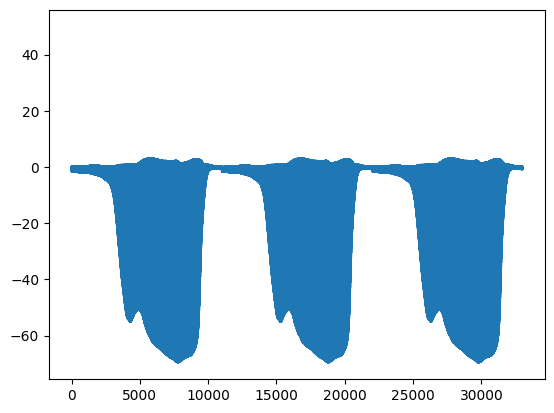

In [68]:


df = pd.read_pickle('./data/ML_Data.pkl')
by_event = False # this makes it so you can switch back and forth between the format we talk about. 3 events per observation or 1 event per observation
nframes = get_number_of_frames(df)
n_events = 3
n_muscles = 11
subject_dfs =  split_by_subject(df)
# find which subjects have at least n working muscles
n = 6
working_subjects = []
for subject_df in subject_dfs:
    if len(get_active_muscles(subject_df)) >= n:
        working_subjects.append(subject_df['Subject'].values[0])
leave_out_df = df[~df['Subject'].isin(working_subjects)]
train_df = df[df['Subject'].isin(working_subjects)]
train_df['Subject'].unique(), leave_out_df['Subject'].unique()
print('TRAINING SET')
# lets make a pretty table of how many subjects have pain and how many don't
pain_df = train_df[train_df['Pain_Cohort'] == 1]
no_pain_df = train_df[train_df['Pain_Cohort'] == 0]
print('Number of subjects with pain: {}'.format(len(pain_df['Subject'].unique())))
print('Number of subjects without pain: {}'.format(len(no_pain_df['Subject'].unique())))
print()
print('LEAVE OUT SET')
# do the same for the leaveout set
pain_df = leave_out_df[leave_out_df['Pain_Cohort'] == 1]
no_pain_df = leave_out_df[leave_out_df['Pain_Cohort'] == 0]
print('Number of subjects with pain: {}'.format(len(pain_df['Subject'].unique())))
print('Number of subjects without pain: {}'.format(len(no_pain_df['Subject'].unique())))

# format data as trajectories
x, y = get_x_y_data(train_df)
y = y.reshape(-1, nframes, 2)
x_og, y_og = get_x_og(train_df)
x = x.reshape(-1, nframes, 11)
x_og = x_og.reshape(-1, nframes, 11)
y_og = y_og.reshape(-1, nframes, 2)
# get the leaveout data and format as trajectories
leaveout_x, leaveout_y = get_x_y_data(leave_out_df)
leaveout_x = to_torch(leaveout_x).float().reshape(-1, nframes, 11)
leaveout_y = to_torch(leaveout_y).float().reshape(-1, nframes, 2)

x.shape, y.shape, x_og.shape, y_og.shape, leaveout_x.shape, leaveout_y.shape
# lets get the datafrom the original dataframe
x_cols = ['Fx', 'Fy', 'Fz', 'FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP','FPB']
y_cols = ['Pain_Cohort', 'Eaton_Litter']
x_data = train_df[x_cols].values
y_data = train_df[y_cols].values
x_data = x_data.reshape(-1, nframes, n_muscles)
y_data = y_data.reshape(-1, nframes, len(y_cols))

x_data.shape, y_data.shape, leaveout_y.shape
# get the data from the leaveout train_df
if by_event:
    leaveout_x = leaveout_x.reshape(-1, nframes*n_muscles)
    # get the value for leaveout_y. Only grab the first value of each evnet
    leaveout_y = leaveout_y[:, 0, :]
    y_data = y_data[:, 0, :]
    y = y[:, 0, :]
    y_og = y_og[:, 0, :]
else:
    leaveout_x = leaveout_x.reshape(-1,  nframes*n_muscles*n_events)
    y_data = y_data.reshape(-1, nframes*n_events, 2)
    leaveout_y = leaveout_y.reshape(-1, nframes*n_events, 2)
    y = y.reshape(-1, nframes*n_events, 2)
    y_og = y_og.reshape(-1, nframes*n_events, 2)
    leaveout_y = leaveout_y[:, 0, :]
    y_data = y_data[:, 0, :]
    y = y[:, 0, :]
    y_og = y_og[:, 0, :]
leaveout_y = to_torch(leaveout_y).float()
leaveout_x.shape, leaveout_y.shape, y_data.shape, y.shape, y_og.shape
# convert the x dimensions depending if we want to group by trajectories or 3 trajectories
if by_event:
    x = x.reshape(-1, nframes*11)
    x_data = x_data.reshape(-1, nframes*11)
    x_og = x_og.reshape(-1, nframes*11)
else:
    x = x.reshape(-1, nframes*11*3)
    x_data = x_data.reshape(-1, nframes*11*3)
    x_og = x_og.reshape(-1, nframes*11*3)

x.shape
plt.plot(x[0,:])
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
x_data = scaler.transform(x_data)
x_og = scaler.transform(x_og)
leaveout_x = scaler.transform(leaveout_x)
x.shape, x_data.shape, x_og.shape, leaveout_x.shape
plt.hist(y[:,0])
plt.hist(y[:,1])
# plot the latent space of the un-augmented data
X_prime, Y_prime = get_data(train_df)
if by_event:
    X_prime = X_prime.reshape(-1, nframes*n_muscles)
    
else:
    X_prime = X_prime.reshape(-1, nframes*n_muscles*n_events)
    Y_prime = Y_prime[::n_events,:]
X_prime = scaler.transform(X_prime)
X_prime.shape, Y_prime.shape
X = to_torch(x)
X_og = to_torch(x_og)
Y = to_torch(y)
X_prime = to_torch(X_prime)
Y_prime = to_torch(Y_prime)

X = torch.cat((X, X_prime), dim=0)
Y = torch.cat((Y, Y_prime), dim=0)
Y_og = torch.cat((Y, Y_prime), dim=0)
X_og = torch.cat((X_og, X_prime), dim=0)
X.shape, Y.shape, X_og.shape, Y_prime.shape

In [74]:
# load the model with dill (reg.dill) 
import dill
reg = dill.load(open('./reg_33000.dill', 'rb'))


In [98]:
# get r2 score of x, x_og, and leaveout_x. (the reconstruction loss of the VAE)
from sklearn.metrics import r2_score
# get the r2 score of the x data
pred_x = to_plot_var(reg.predict(X))
pred_x_og = to_plot_var(reg.predict(X_og))
pred_leaveout_x = to_plot_var(reg.predict(to_torch(leaveout_x).float()))
r2_score(X, pred_x), r2_score(X_og, pred_x_og), r2_score(leaveout_x, pred_leaveout_x)

(0.7479534444435935, 0.9569398039940252, -6.909251175326169)

In [99]:
leaveout_x_encoded = to_plot_var(reg.estimator.encode(to_torch(leaveout_x))[0])
x_encoded = to_plot_var(reg.estimator.encode(X)[0])
Y = to_plot_var(Y)
leaveout_y = to_plot_var(leaveout_y)
leaveout_y.shape, leaveout_x_encoded.shape

((32, 2), (32, 2))

In [100]:
# use logistic regression to predict the pain cohort
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(x_encoded, Y[:,0])
log_reg.score(x_encoded, Y[:,0]), log_reg.score(leaveout_x_encoded, leaveout_y[:,0])

(0.7222222222222222, 0.46875)

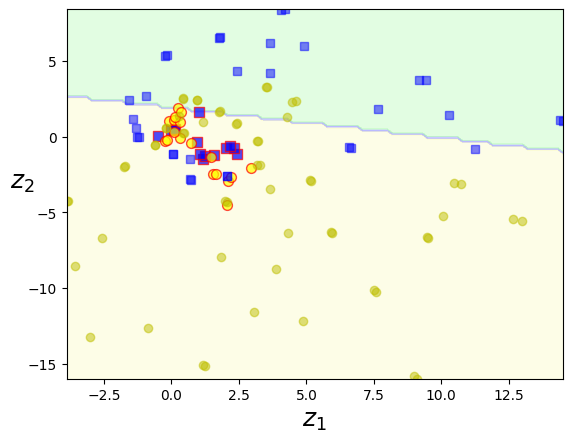

In [101]:
# plot the decision boundary
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    # create a meshgrid
    x1, x2 = np.meshgrid(x1s, x2s)
    # flatten the meshgrid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    # make predictions
    y_pred = clf.predict(X_new).reshape(x1.shape)
    # plot the contour
    if contour:
        custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
        plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    # plot the scatter plot
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$z_1$", fontsize=18)
    plt.ylabel(r"$z_2$", fontsize=18, rotation=0)

axes = [np.min(x_encoded[:,0]), np.max(x_encoded[:,0]), np.min(x_encoded[:,1]), np.max(x_encoded[:,1])]
plot_decision_boundary(log_reg, x_encoded, Y[:,0], axes=axes)
# plot the leaveout data
# use red outlines for the leaveout data
# use the same symbol scheme for pain
plt.scatter(leaveout_x_encoded[:,0][leaveout_y[:,0]==0], leaveout_x_encoded[:,1][leaveout_y[:,0]==0], c='blue', edgecolors='r', s=50, alpha=0.7, marker='s')
plt.scatter(leaveout_x_encoded[:,0][leaveout_y[:,0]==1], leaveout_x_encoded[:,1][leaveout_y[:,0]==1], c='yellow', edgecolors='r', s=50, alpha=0.7, marker='o')

In [105]:
# use a random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
rf_reg = RandomForestClassifier()
rf_reg.fit(x_encoded, Y[:,0])
rf_reg.score(x_encoded, Y[:,0]), rf_reg.score(leaveout_x_encoded, leaveout_y[:,0])

(1.0, 0.4375)

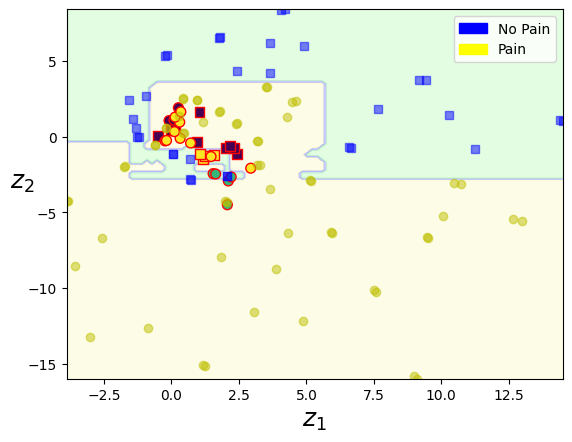

In [106]:
plot_decision_boundary(rf_reg, x_encoded, Y[:,0], axes=axes)
# plot the leaveout data
# use red outlines for the leaveout data
# use the same symbol scheme for pain
plt.scatter(leaveout_x_encoded[:,0][leaveout_y[:,0]==0], leaveout_x_encoded[:,1][leaveout_y[:,0]==0], c=leaveout_y[:,1][leaveout_y[:,0] ==0], edgecolors='r', s=50, marker='s')

plt.scatter(leaveout_x_encoded[:,0][leaveout_y[:,0]==1], leaveout_x_encoded[:,1][leaveout_y[:,0]==1], c=leaveout_y[:,1][leaveout_y[:,0] ==1], edgecolors='r', s=50, marker='o')

# create a legend for the background color used for the decision boundary
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', label='No Pain')
yellow_patch = mpatches.Patch(color='yellow', label='Pain')
plt.legend(handles=[blue_patch, yellow_patch], loc='upper right')

In [104]:
# lets see what the model's predictions are for data that has been augmented. 
# reshape x and x_og back to trajectories
x = x.reshape(-1, nframes, 11)
x_og = x_og.reshape(-1, nframes, 11)
